# Регрессионный анализ

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.stats.diagnostic import het_white
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import PowerTransformer

In [2]:
df = pd.read_csv("C:\\Users\\Администратор\\Downloads\\SeoulBikeData.csv", encoding='windows-1251')

In [3]:
print("Количество строк в наборе данных = {}".format(df.shape[0]))
print("Количество столбцов в наборе данных = {}".format(df.shape[1]))

Количество строк в наборе данных = 8760
Количество столбцов в наборе данных = 14


In [4]:
df.head(7)

Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0  01/12/2017                254     0             -5.2           37   
1  01/12/2017                204     1             -5.5           38   
2  01/12/2017                173     2             -6.0           39   
3  01/12/2017                107     3             -6.2           40   
4  01/12/2017                 78     4             -6.0           36   
5  01/12/2017                100     5             -6.4           37   
6  01/12/2017                181     6             -6.6           35   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   
5               1.5              2000                      -18.7   
6               1.3              2000                      -19.5   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   
1                      0.0           0.0            0.0  Winter  No Holiday   
2                      0.0           0.0            0.0  Winter  No Holiday   
3                      0.0           0.0            0.0  Winter  No Holiday   
4                      0.0           0.0            0.0  Winter  No Holiday   
5                      0.0           0.0            0.0  Winter  No Holiday   
6                      0.0           0.0            0.0  Winter  No Holiday   

  Functioning Day  
0             Yes  
1             Yes  
2             Yes  
3             Yes  
4             Yes  
5             Yes  
6             Yes

В настоящее время прокат велосипедов вводится во многих городах для повышения комфорта передвижения. Важно сделать арендованный велосипед доступным для публики в нужное время, поскольку это сокращает время ожидания. В конце концов, обеспечение города стабильным запасом прокатных велосипедов становится серьезной проблемой. Важнейшей частью является прогнозирование количества велосипедов, необходимого в каждый час для стабильного предложения прокатных велосипедов.

Набор данных содержит информацию о погоде (температура, влажность, скорость ветра, видимость, точка росы, солнечная радиация, снегопад, осадки), количество арендованных велосипедов в час и информацию о дате.

Дата : год-месяц-день

Количество арендованных велосипедов - количество велосипедов, арендованных за каждый час.

Час - Час этого дня

Температура - Температура в градусах Цельсия

Влажность - %

Скорость ветра - м/с

Видимость - 10 м

Температура точки росы - Цельсий

Солнечная радиация - МДж/м2

Количество осадков, мм

Снегопад - см

Времена года - Зима, Весна, Лето, Осень

Праздник - Праздник/без праздника

Функциональный день - NoFunc (нерабочие часы), Fun(функциональные часы)

Сначала необходимо проверить данные:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

Столбец с датами не играет роли для построения регрессионной модели, так как признаки времени года, рабочего/нерабочего дня, праздничного/непраздничного дня гораздо важнее, то данный признак можно удалить.

In [6]:
df = df.drop(columns={'Date'})

В наборе данных нет пропущенных данных, однако имеются колонки категориальных признаков, которые необходимо преобразовать в числовые.

In [7]:
cat_col = df.select_dtypes(include=['object']).columns
cat = df[cat_col]
cat.columns

Index(['Seasons', 'Holiday', 'Functioning Day'], dtype='object')

In [8]:
for index in range(len(cat.columns)):
    print(set(df[cat.columns[index]]))

{'Summer', 'Winter', 'Spring', 'Autumn'}
{'No Holiday', 'Holiday'}
{'No', 'Yes'}


In [9]:
seasons_map = {'Winter':0, 'Autumn':1, 'Spring':2, 'Summer':3}
holiday_map = {'No Holiday':0, 'Holiday':1}
functioning_day_map = {'No':0, 'Yes':1}

In [10]:
df[cat.columns[0]] = df[cat.columns[0]].map(seasons_map)
df[cat.columns[1]] = df[cat.columns[1]].map(holiday_map)
df[cat.columns[2]] = df[cat.columns[2]].map(functioning_day_map)

In [11]:
df.head()

Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
0                254     0             -5.2           37               2.2   
1                204     1             -5.5           38               0.8   
2                173     2             -6.0           39               1.0   
3                107     3             -6.2           40               0.9   
4                 78     4             -6.0           36               2.3   

   Visibility (10m)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  \
0              2000                      -17.6                      0.0   
1              2000                      -17.6                      0.0   
2              2000                      -17.7                      0.0   
3              2000                      -17.6                      0.0   
4              2000                      -18.6                      0.0   

   Rainfall(mm)  Snowfall (cm)  Seasons  Holiday  Functioning Day  
0           0.0            0.0        0        0                1  
1           0.0            0.0        0        0                1  
2           0.0            0.0        0        0                1  
3           0.0            0.0        0        0                1  
4           0.0            0.0        0        0                1

Разделим признаки:

In [12]:
target_col = 'Rented Bike Count'
X = df.loc[:, df.columns != target_col]
y = df.loc[:, target_col]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, 
                                                    random_state=42)

# Линейная регрессия (statsmodels)

In [14]:
X_with_constant = sm.add_constant(X_train)
model = sm.OLS(y_train, X_with_constant)

In [15]:
results = model.fit()
results.params

const                       -239.315270
Hour                          28.433748
Temperature(°C)               24.911892
Humidity(%)                   -8.998001
Wind speed (m/s)               6.810577
Visibility (10m)               0.030561
Dew point temperature(°C)      8.232056
Solar Radiation (MJ/m2)      -74.979484
Rainfall(mm)                 -68.539297
Snowfall (cm)                  8.047634
Seasons                      -13.123209
Holiday                     -146.885139
Functioning Day              836.764409
dtype: float64

In [16]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Rented Bike Count   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     574.4
Date:                Sat, 08 Apr 2023   Prob (F-statistic):               0.00
Time:                        20:47:30   Log-Likelihood:                -46076.
No. Observations:                6132   AIC:                         9.218e+04
Df Residuals:                    6119   BIC:                         9.227e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      -239.3153    117.517     -2.036      0.042    -469.691      -8.940
Hour                         28.4337      0.904     31.447      0.000      26.661      30.206
Temperature(°C)              24.9119      4.476      5.565      0.000      16.137      33.687
Humidity(%)                  -8.9980      1.259     -7.145      0.000     -11.467      -6.529
Wind speed (m/s)              6.8106      6.187      1.101      0.271      -5.317      18.938
Visibility (10m)              0.0306      0.012      2.610      0.009       0.008       0.054
Dew point temperature(°C)     8.2321      4.696      1.753      0.080      -0.975      17.439
Solar Radiation (MJ/m2)     -74.9795      9.231     -8.123      0.000     -93.075     -56.884
Rainfall(mm)                -68.5393      5.809    -11.799      0.000     -79.927     -57.152
Snowfall (cm)                 8.0476     13.358      0.602      0.547     -18.138      34.233
Seasons                     -13.1232      9.110     -1.441      0.150     -30.982       4.736
Holiday                    -146.8851     26.390     -5.566      0.000    -198.618     -95.152
Functioning Day             836.7644     31.828     26.290      0.000     774.370     899.158
==============================================================================
Omnibus:                      861.884   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1604.161
Skew:                           0.897   Prob(JB):                         0.00
Kurtosis:                       4.750   Cond. No.                     3.25e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

1. Коэффициенты регрессии модели Y = b0 + b1∙d1 + b2∙d2 + b3∙d3 + b4∙d4 + b5∙d5 + b6∙d6 + b7∙d7 + b8∙d8 + b9∙d9 + b10∙d10 + b11∙d11 + b12∙d12:


> Intercept = b0 = -239.3153

>b1  = 28.4337
>b2  = 24.9119
>b3  = -8.9980
>b4  = 6.8106
>b5  = 0.0306
>b6  = 8.2321	
>b7  = -74.9795
>b8  = -68.5393
>b9  = 8.0476
>b10 = -13.1232
>b11 = -146.8851
>b12 = 836.7644


2. Коэффициент детерминации R-squared = 0.530, его скорректированная оценка Adj. R-squared = 0.529 - это означает, что регрессионная модель объясняет 53% вариации переменной Y.


3. Проверка значимости коэффициента детерминации:

>расчетное значение статистики критерия Фишера: F-statistic = 574.4

>расчетный уровень значимости Prob (F-statistic) = 0

>так как значение Prob (F-statistic) < 0.05, то нулевая гипотеза R-squared = 0 НЕ ПРИНИМАЕТСЯ, т.е. коэффициент детерминации ЗНАЧИМ

4. Проверка значимости коэффициентов регрессии:

>расчетный уровень значимости P>|t| для b0, b1, b2, b3, b5, b7, b8, b11, b12 не превышает 0.05 - это означает, что коэффициенты регрессии значимы

>об этом же свидетельствует то, что доверительный интервал для коэффициентов регрессии ([0.025; 0.975]) не включает в себя точку 0

>расчетный уровень значимости P>|t| для b4, b6, b9, b10 превышает 0.05. Нулевая гипотеза не отвергается. b3 не является значимым.
Нулевая гипотеза - коэффициет равен нулю, альтернативная - не равен.

5. значение t для b4, b6, b10 велико, для b9 (чем выше значение t, тем выше шанс, что мы отвергаем нулевую гипотезу).

Также в таблице результатов содержится прочая информация по коэффициентам регрессии: стандартная ошибка Std.Err. 

In [17]:
X_test = sm.add_constant(X_test)

In [18]:
y_pred = results.predict(X_test)
y_pred

6056    1036.028437
5556    1224.277167
5990    1470.689836
7674    1190.829671
3319     481.369277
           ...     
3404    1475.279121
1912     867.125772
3692    1122.638902
599      585.534592
45       820.479799
Length: 2628, dtype: float64

In [19]:
residual = y_test - y_pred
residual

6056     691.971563
5556    -402.277167
5990    -812.689836
7674    1525.170329
3319     601.630723
           ...     
3404     105.720879
1912    -463.125772
3692     278.361098
599     -416.534592
45      -443.479799
Length: 2628, dtype: float64

# Предпосылки линейной регрессии
Модель линейной регрессии можно построить не для любых данных, а только для данных, которые удовлетворяют ряду условий. И прежде, чем использовать регрессионное уравнение для прогнозирования, необходимо проверить выполнение этих условий. В ином случае наша модель не будет адекватна поставленной задаче, и ее использование будет бессмысленно.

# Наличие линейной зависимости
Первая и самая естественная предпосылка заключается в линейности модели. Под этим условием подразумевается корректность модели, выбор адекватных предикторов и отсутствие лишних предикторов. А также линейную зависимость целевой переменной от независимых переменных.

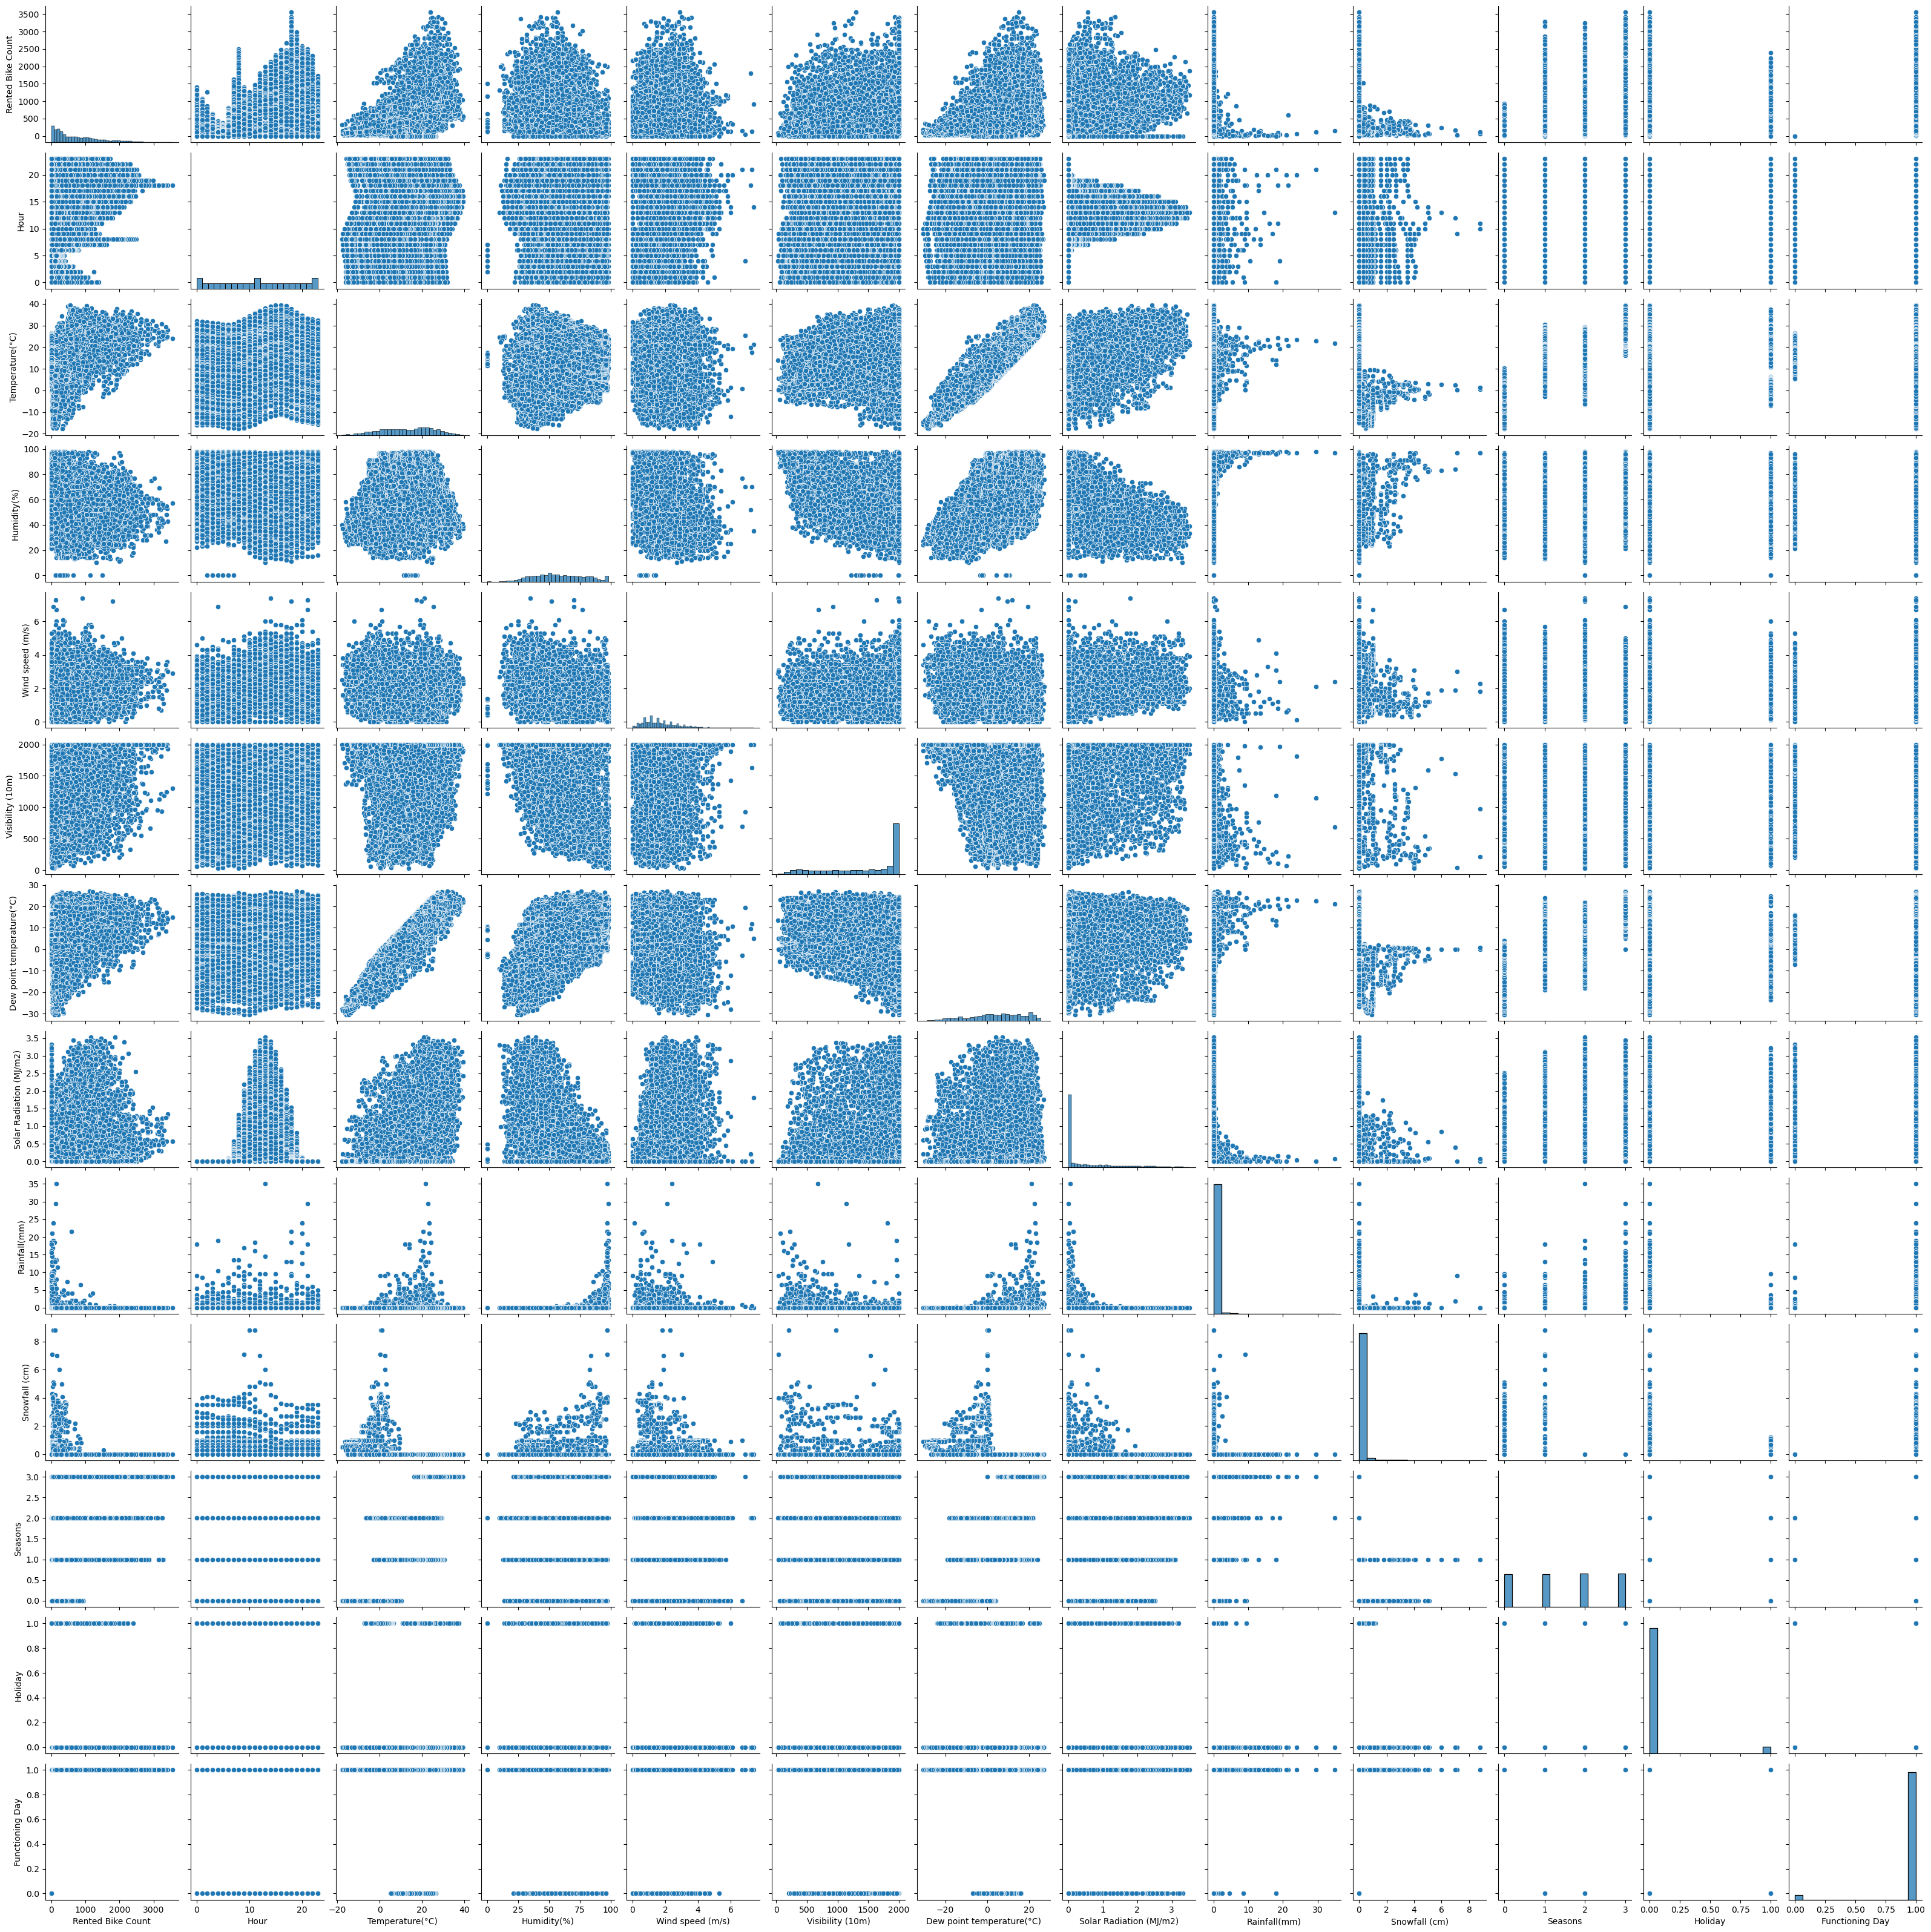

In [20]:
sns.pairplot(df)

По данным графикам можно сказать, что на них в меньшей степени наблюдается линейная зависимость, так как на первых графиках достаточно болльшой разброс данных, а на последних графиках заметно равномерное распределение.

# Отсутствие мультиколлинеарности

Мультиколлинеарностью называют явление, которое заключается в наличии линейной зависимости между независимыми переменными (предикторами). Такое может возникать, например, при использовании признаков с естественной взаимосвязью: стаж работы и возраст (как правило, чем больше возраст - тем больше стаж и наоборот), количество детских садов и количество школ в районе (обычно детские сады бывают при школе, так что эти количества пропорционально взаимосвязаны) или баллы за экзамены IELTS и TOEFL (так как они экзамены проверяют примерно одни и те же знания и навыки)

Последствием мультиколлинеарности является расширение доверительных интервалов для коэффициентов, и модель получается очень неустойчивой и меняющейся от добавления даже 1-2 новых наблюдений. Разумеется, это не очень хорошая для нас ситуация, поэтому мы должны отбирать для модели только те предикторы, между которыми нет линейной связи.

Для того чтобы проверить данную предпосылку, нам необходимо построить матрицу корреляций для всех потенциальных предикторов, и отследить наличие сильной корреляционной связи. Нет четкой границы, которая отделяет допустимую взаимосвязь и недопустимую, но в ряде источников используется граница в районе 0.9. То есть, если между предикторами коэффициент корреляции по модулю больше, чем 0.9, то мы не можем оба этих предиктора использовать для модели.


In [20]:
correlation = df.corr()
correlation

Rented Bike Count          Hour  Temperature(°C)  \
Rented Bike Count                   1.000000  4.102573e-01         0.538558   
Hour                                0.410257  1.000000e+00         0.124114   
Temperature(°C)                     0.538558  1.241145e-01         1.000000   
Humidity(%)                        -0.199780 -2.416438e-01         0.159371   
Wind speed (m/s)                    0.121108  2.851967e-01        -0.036252   
Visibility (10m)                    0.199280  9.875348e-02         0.034794   
Dew point temperature(°C)           0.379788  3.054372e-03         0.912798   
Solar Radiation (MJ/m2)             0.261837  1.451309e-01         0.353505   
Rainfall(mm)                       -0.123074  8.714642e-03         0.050282   
Snowfall (cm)                      -0.141804 -2.151645e-02        -0.218405   
Seasons                             0.403492  8.714834e-16         0.805959   
Holiday                            -0.072338 -1.391486e-16        -0.055931   
Functioning Day                     0.203943  5.439377e-03        -0.050170   

                           Humidity(%)  Wind speed (m/s)  Visibility (10m)  \
Rented Bike Count            -0.199780          0.121108          0.199280   
Hour                         -0.241644          0.285197          0.098753   
Temperature(°C)               0.159371         -0.036252          0.034794   
Humidity(%)                   1.000000         -0.336683         -0.543090   
Wind speed (m/s)             -0.336683          1.000000          0.171507   
Visibility (10m)             -0.543090          0.171507          1.000000   
Dew point temperature(°C)     0.536894         -0.176486         -0.176630   
Solar Radiation (MJ/m2)      -0.461919          0.332274          0.149738   
Rainfall(mm)                  0.236397         -0.019674         -0.167629   
Snowfall (cm)                 0.108183         -0.003554         -0.121695   
Seasons                       0.247832         -0.059847         -0.028046   
Holiday                      -0.050278          0.023017          0.031773   
Functioning Day              -0.020800          0.005037         -0.026000   

                           Dew point temperature(°C)  Solar Radiation (MJ/m2)  \
Rented Bike Count                           0.379788                 0.261837   
Hour                                        0.003054                 0.145131   
Temperature(°C)                             0.912798                 0.353505   
Humidity(%)                                 0.536894                -0.461919   
Wind speed (m/s)                           -0.176486                 0.332274   
Visibility (10m)                           -0.176630                 0.149738   
Dew point temperature(°C)                   1.000000                 0.094381   
Solar Radiation (MJ/m2)                     0.094381                 1.000000   
Rainfall(mm)                                0.125597                -0.074290   
Snowfall (cm)                              -0.150887                -0.072301   
Seasons                                     0.786879                 0.199799   
Holiday                                    -0.066759                -0.005077   
Functioning Day                            -0.052837                -0.007665   

                           Rainfall(mm)  Snowfall (cm)       Seasons  \
Rented Bike Count             -0.123074      -0.141804  4.034924e-01   
Hour                           0.008715      -0.021516  8.714834e-16   
Temperature(°C)                0.050282      -0.218405  8.059586e-01   
Humidity(%)                    0.236397       0.108183  2.478317e-01   
Wind speed (m/s)              -0.019674      -0.003554 -5.984683e-02   
Visibility (10m)              -0.167629      -0.121695 -2.804593e-02   
Dew point temperature(°C)      0.125597      -0.150887  7.868789e-01   
Solar Radiation (MJ/m2)       -0.074290      -0.072301  1.997987e-01   
Rainfall(mm)                   1.000000     

<AxesSubplot: >

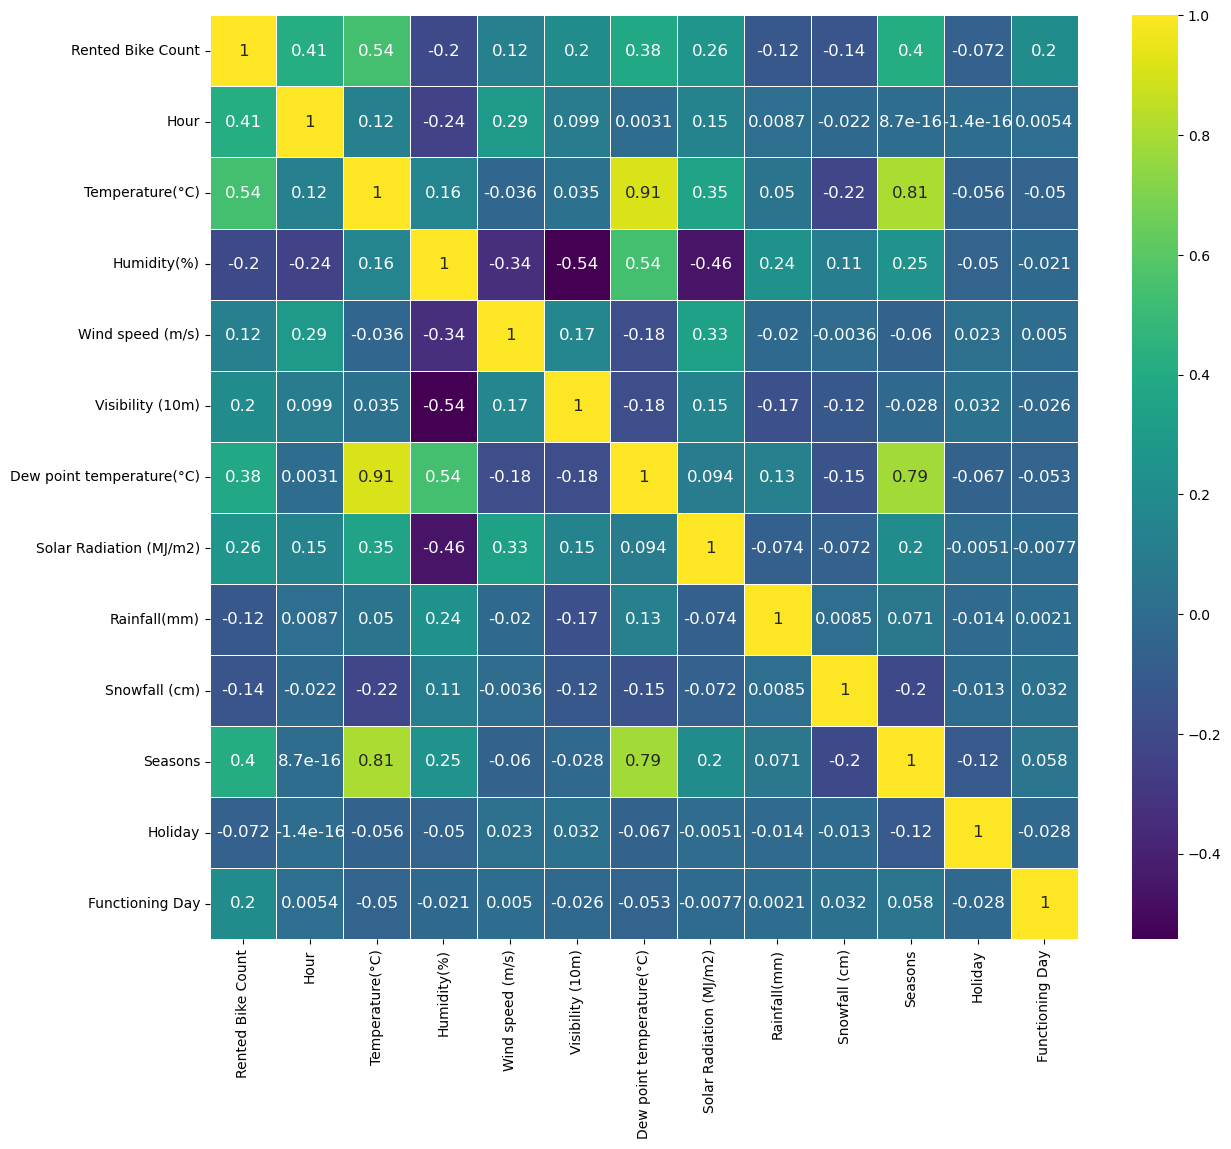

In [21]:
fig , ax = plt.subplots(figsize = (14,12))

sns.heatmap(correlation, 
            linewidths=0.5, annot=True,cmap='viridis',
            linecolor="white", annot_kws = {'size':12})

In [22]:
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
pd.DataFrame({'vif': vif[0:]}, index=X_train.columns).T

Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
vif  4.540544        48.549053    17.895057          4.836147   

     Visibility (10m)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  \
vif          9.192273                  25.491952                 2.932884   

     Rainfall(mm)  Snowfall (cm)   Seasons   Holiday  Functioning Day  
vif      1.094606       1.125187  9.117457  1.072483        28.514063

Параметры температуры в цельсиях, влажности в процентах, солнечной радиации и рабочих\нерабочих дней наиболее коллинеарные.

# Нормальное распределение ошибок
После того как мы построили модель регрессии, мы можем вычислить ошибки (остатки): разницы между реальным значением $y$ и предсказанным $\hat{y}$. Важным условием является нормальность распределения этих ошибок. То есть, распределение остатков должно стремиться к нормальному распределению. Проверить выполняемость этого условия можно визуально с помощью гистограммы или с помощью специальных статистических тестов.

В целом, такое условие связано не напрямую с остатками, а с тем, что зависимая переменная должна быть распределена нормально для любых значений х. Однако такое условие проверить довольно сложно, поэтому можно проверить такое условие с помощью анализа распределения остатков.

<AxesSubplot: ylabel='Density'>

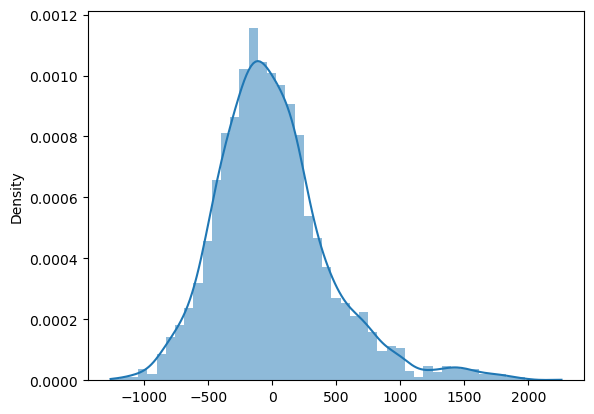

In [23]:
sns.histplot(residual, kde=True, stat="density", linewidth=0)

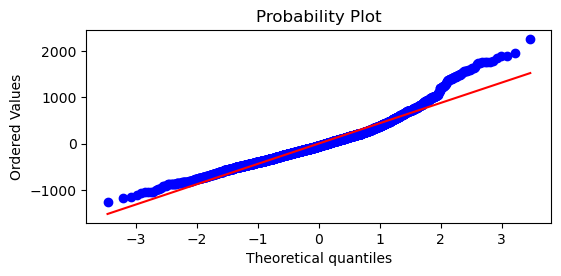

In [24]:
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)

In [25]:
np.mean(residual)

4.814038162379592

Судя по этим графикам, можно сказать, что остатки распределены нормально и без значительных выбросов.

# Гомоскедастичность 
Гомоскедастичность ошибок заключается в том, что разброс остатков при любых значениях независимых переменных одинаковый. Предположим, что мы хотим предсказать стоимость квартиры по каким-то ее признакам. Если для квартир площадью 30-50 метров разброс ошибок будет маленький, а для квартир, площадью 50-70 метров разброс ошибок будет очень большой, то мы будем иметь дело с гетероскедастичностью. Такая ситуация нас не устраивает. Нам важно, чтобы качество модели было одно и то же при любых значениях независимой переменной.

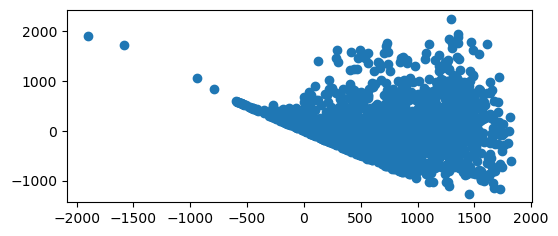

In [26]:
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_pred, residual)

In [27]:
white_test = het_white(results.resid, results.model.exog)
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
dict(zip(labels, np.round(white_test, 4)))

{'Test Statistic': 980.9949,
 'Test Statistic p-value': 0.0,
 'F-Statistic': 13.2306,
 'F-Test p-value': 0.0}

Так уровень p-значимости критерии Фишера равен нулю, что позволяет утверждать об отсуствии гетероскедастичности.

# Отсутствие автокорреляции остатков
Автокорреляция остатков (ошибок) возникает в ситуации, когда есть линейная взаимосвязь между остатками для одних значений предикторов и остатками для других значений предикторов. Такое может проявляться в силу естественных причин, как и в случае сс мультиколлинеарностью. Например, если мы предсказываем какие-то показатели для соседних регионов страны, то, скорее всего, они будут сильно взаимосвязаны просто в силу схожести характеристик этих объектов.

Автокорреляция влечет за собой некорректные результаты. Стандартные ошибки получаются несостоятельными, и мы не можем строить корректные доверительные интервалы и проверять гипотезы классическими способами.

C:\Users\Администратор\AppData\Local\Temp\ipykernel_3172\1706020188.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  acf.show()


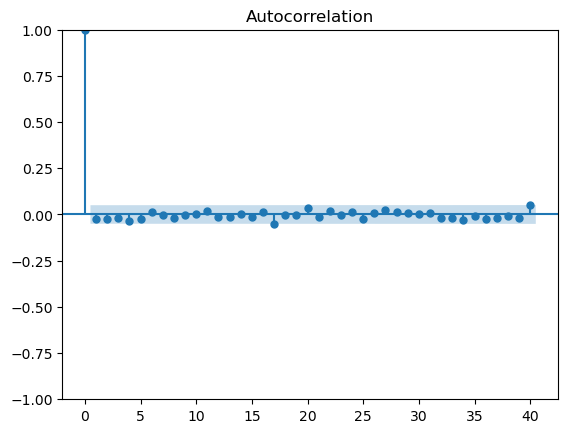

In [28]:
acf = smt.graphics.plot_acf(residual, lags=40 , alpha=0.01)
acf.show()

На данном графике при параметре альфа равном 0.01 отсуствует существенная автокорреляция остатков,что свидетельствует об отсуствии линейной взаимосвязи между остатками предикторов.

# Повторный регрессионный анализ

В ходе анализа были выяснены коэффициенты корреляции, линейная взаимосвязь предикторов и значимые коэффициенты, что позволяет провести повторный регрессионный анализ.

In [29]:
new_df = df.drop(columns={'Wind speed (m/s)','Solar Radiation (MJ/m2)', 'Dew point temperature(°C)', 'Snowfall (cm)', 'Seasons', 'Functioning Day', 'Visibility (10m)'})
new_df

Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  Rainfall(mm)  \
0                   254     0             -5.2           37           0.0   
1                   204     1             -5.5           38           0.0   
2                   173     2             -6.0           39           0.0   
3                   107     3             -6.2           40           0.0   
4                    78     4             -6.0           36           0.0   
...                 ...   ...              ...          ...           ...   
8755               1003    19              4.2           34           0.0   
8756                764    20              3.4           37           0.0   
8757                694    21              2.6           39           0.0   
8758                712    22              2.1           41           0.0   
8759                584    23              1.9           43           0.0   

      Holiday  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
8755        0  
8756        0  
8757        0  
8758        0  
8759        0  

[8760 rows x 6 columns]

In [30]:
new_df.describe()

Rented Bike Count         Hour  Temperature(°C)  Humidity(%)  \
count        8760.000000  8760.000000      8760.000000  8760.000000   
mean          704.602055    11.500000        12.882922    58.226256   
std           644.997468     6.922582        11.944825    20.362413   
min             0.000000     0.000000       -17.800000     0.000000   
25%           191.000000     5.750000         3.500000    42.000000   
50%           504.500000    11.500000        13.700000    57.000000   
75%          1065.250000    17.250000        22.500000    74.000000   
max          3556.000000    23.000000        39.400000    98.000000   

       Rainfall(mm)      Holiday  
count   8760.000000  8760.000000  
mean       0.148687     0.049315  
std        1.128193     0.216537  
min        0.000000     0.000000  
25%        0.000000     0.000000  
50%        0.000000     0.000000  
75%        0.000000     0.000000  
max       35.000000     1.000000

В столбце Температура имеются отрицательные значения и во всех столбцах имеются значения нуля.

Для приведения нелинейных признаков к линейным было проведено преобразование Йео-Джонсона (Yeo-Johnson transformation), которое позволяет работать с нулевыми и отрицательными значениями, так как логарифм нуля и отрицательных значений неопределен.

In [31]:
pt = PowerTransformer()

In [32]:
tmp = pt.fit_transform(new_df[['Hour', 'Temperature(°C)', 'Humidity(%)', 'Rainfall(mm)', 'Holiday']])
new_df[['Hour', 'Temperature(°C)', 'Humidity(%)', 'Rainfall(mm)', 'Holiday']] = tmp
new_df

Rented Bike Count      Hour  Temperature(°C)  Humidity(%)  Rainfall(mm)  \
0                   254 -1.902967        -1.524521    -1.038829     -0.252859   
1                   204 -1.654871        -1.550870    -0.986482     -0.252859   
2                   173 -1.440263        -1.594819    -0.934363     -0.252859   
3                   107 -1.244866        -1.612409    -0.882465     -0.252859   
4                    78 -1.062616        -1.594819    -1.091410     -0.252859   
...                 ...       ...              ...          ...           ...   
8755               1003  1.050241        -0.715942    -1.197308     -0.252859   
8756                764  1.170220        -0.783248    -1.038829     -0.252859   
8757                694  1.288636        -0.850709    -0.934363     -0.252859   
8758                712  1.405578        -0.892966    -0.830782     -0.252859   
8759                584  1.521129        -0.909892    -0.728037     -0.252859   

       Holiday  
0    -0.227757  
1    -0.227757  
2    -0.227757  
3    -0.227757  
4    -0.227757  
...        ...  
8755 -0.227757  
8756 -0.227757  
8757 -0.227757  
8758 -0.227757  
8759 -0.227757  

[8760 rows x 6 columns]

Далее проводим повторный анализ.

In [33]:
target_col = 'Rented Bike Count'
X = new_df.loc[:, new_df.columns != target_col]
y = new_df.loc[:, target_col]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, 
                                                    random_state=42)

In [35]:
X_with_constant = sm.add_constant(X_train)
model = sm.OLS(y_train, X_with_constant)

In [36]:
results = model.fit()
results.params = (np.exp(results.params)-np.exp(-results.params))/2
results.params

const              1.126058e+305
Hour                1.204152e+88
Temperature(°C)    7.676129e+147
Humidity(%)        -8.814879e+34
Rainfall(mm)       -1.746493e+54
Holiday            -5.223435e+14
dtype: float64

In [37]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Rented Bike Count   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     1140.
Date:                Sat, 08 Apr 2023   Prob (F-statistic):               0.00
Time:                        20:47:41   Log-Likelihood:                -46373.
No. Observations:                6132   AIC:                         9.276e+04
Df Residuals:                    6126   BIC:                         9.280e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             703.1003      5.950    118.161      0.000     691.435     714.765
Hour              203.5064      6.312     32.240      0.000     191.132     215.881
Temperature(°C)   341.2113      6.141     55.561      0.000     329.172     353.250
Humidity(%)       -81.1575      6.782    -11.967      0.000     -94.452     -67.863
Rainfall(mm)     -125.5904      6.395    -19.639      0.000    -138.127    -113.054
Holiday           -34.5825      5.946     -5.816      0.000     -46.238     -22.927
==============================================================================
Omnibus:                      691.338   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1311.120
Skew:                           0.738   Prob(JB):                    1.97e-285
Kurtosis:                       4.718   Cond. No.                         1.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

1. Коэффициенты регрессии модели Y = b0 + b1∙d1 + b2∙d2 + b3∙d3 + b4∙d4 + b5∙d5:


> Intercept = b0 = 703.1003

>b1  = 203.5064
>b2  = 341.2113
>b3  = -81.1575
>b4  = -125.5904
>b5  = -34.5825	


2. Коэффициент детерминации R-squared = 0.482, его скорректированная оценка Adj. R-squared = 0.482 - это означает, что регрессионная модель объясняет 48.2% вариации переменной Y.


3. Проверка значимости коэффициента детерминации:

>расчетное значение статистики критерия Фишера: F-statistic = 1140

>расчетный уровень значимости Prob (F-statistic) = 0.0

>так как значение Prob (F-statistic) < 0.05, то нулевая гипотеза R-squared = 0 НЕ ПРИНИМАЕТСЯ, т.е. коэффициент детерминации ЗНАЧИМ

4. Проверка значимости коэффициентов регрессии:

>расчетный уровень значимости P>|t| для b0, b1, b2, b3, b4, b5, b6 не превышает 0.05 - это означает, что коэффициенты регрессии значимы

>об этом же свидетельствует то, что доверительный интервал для коэффициентов регрессии ([0.025; 0.975]) не включает в себя точку 0

In [38]:
X_test = sm.add_constant(X_test)

In [39]:
y_pred = results.predict(X_test)
np.round(y_pred)

6056    1020.0
5556    1359.0
5990    1456.0
7674    1091.0
3319     472.0
         ...  
3404    1329.0
1912     842.0
3692    1018.0
599      508.0
45       768.0
Length: 2628, dtype: float64

In [40]:
residual = y_test - y_pred
residual

6056     707.560606
5556    -536.772278
5990    -798.273748
7674    1625.159718
3319     610.715310
           ...     
3404     251.928170
1912    -437.843284
3692     382.598184
599     -338.793956
45      -391.122072
Length: 2628, dtype: float64

# Наличие линейной зависимости

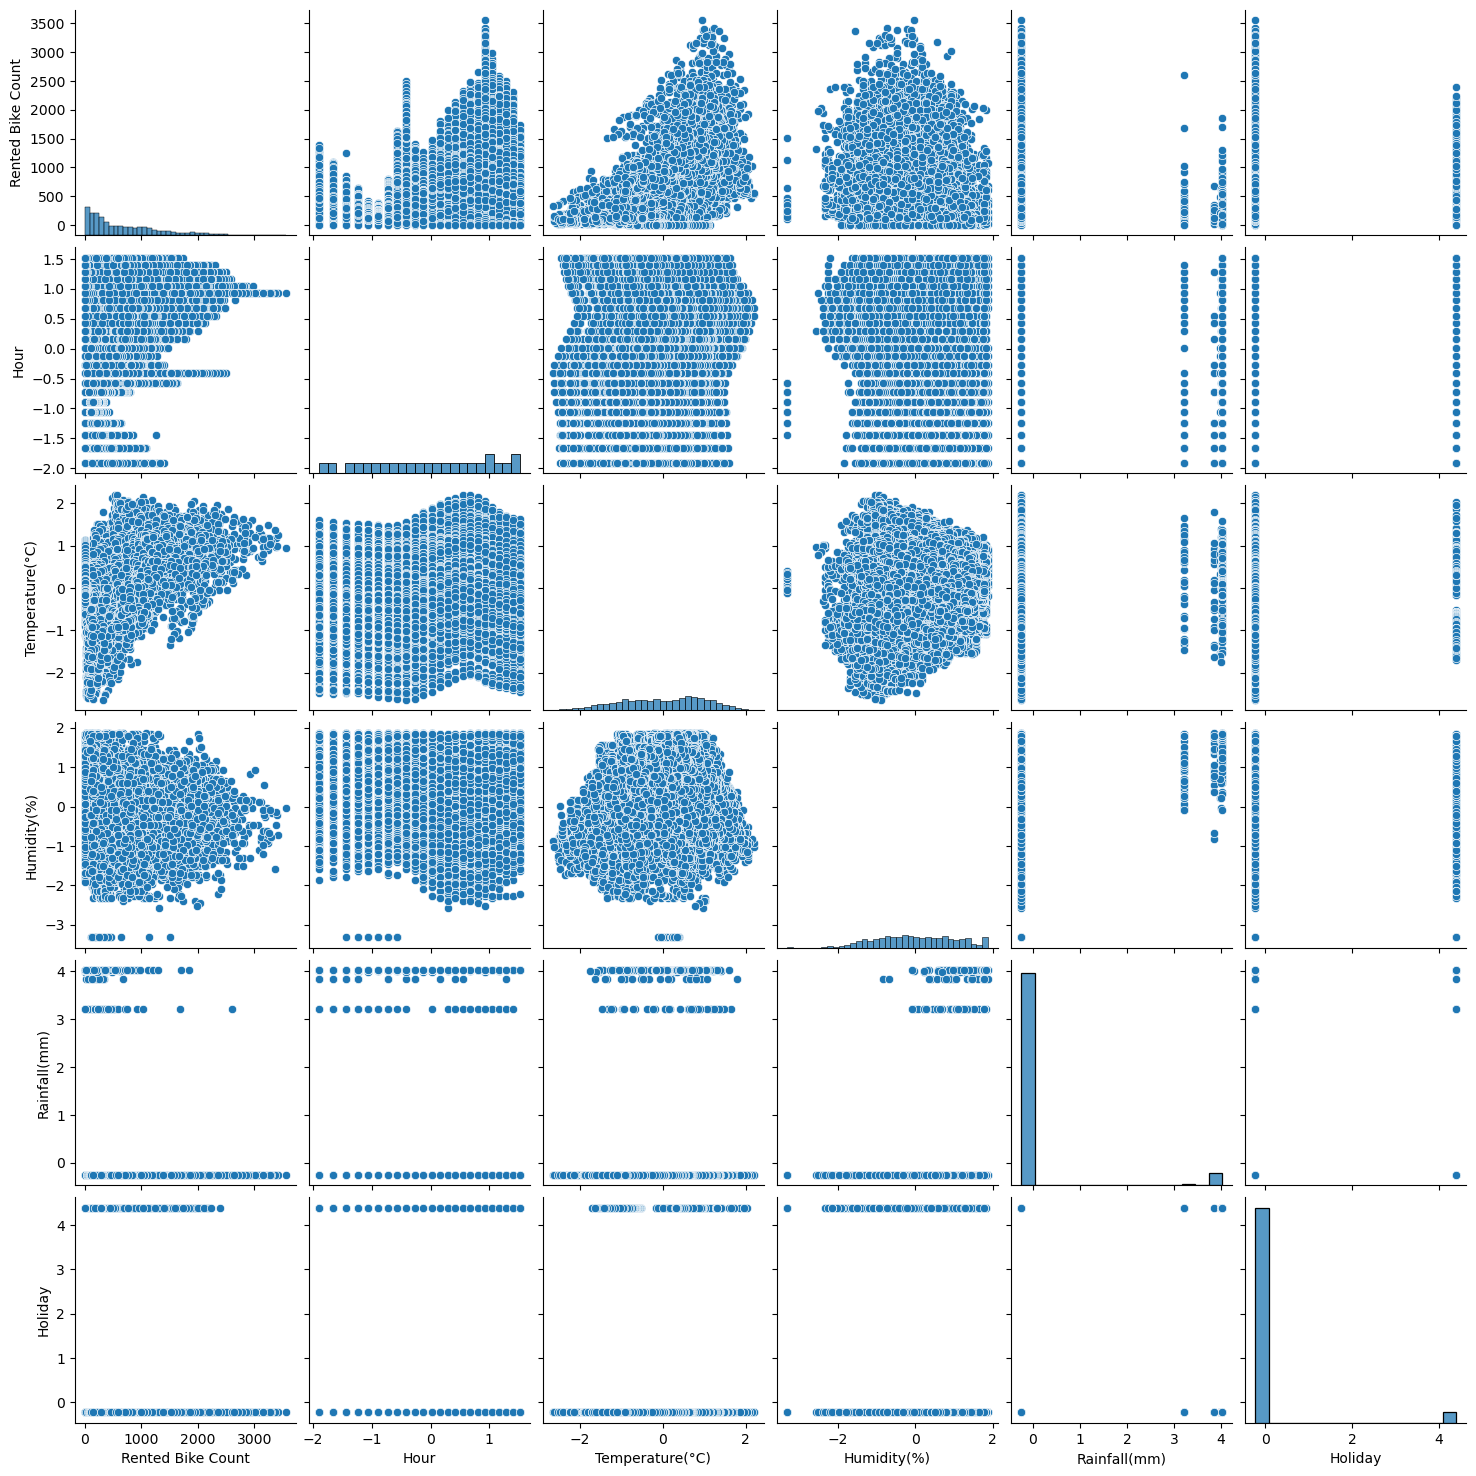

In [41]:
sns.pairplot(new_df)

# Отсутствие мультиколлинеарности

In [42]:
correlation = new_df.corr()
correlation

Rented Bike Count          Hour  Temperature(°C)  \
Rented Bike Count           1.000000  4.078944e-01         0.538008   
Hour                        0.407894  1.000000e+00         0.127733   
Temperature(°C)             0.538008  1.277333e-01         1.000000   
Humidity(%)                -0.192832 -2.535362e-01         0.163871   
Rainfall(mm)               -0.213277 -2.547044e-02         0.075267   
Holiday                    -0.072338 -5.576463e-18        -0.055329   

                   Humidity(%)  Rainfall(mm)       Holiday  
Rented Bike Count    -0.192832     -0.213277 -7.233757e-02  
Hour                 -0.253536     -0.025470 -5.576463e-18  
Temperature(°C)       0.163871      0.075267 -5.532929e-02  
Humidity(%)           1.000000      0.387916 -5.166701e-02  
Rainfall(mm)          0.387916      1.000000 -1.209089e-02  
Holiday              -0.051667     -0.012091  1.000000e+00

<AxesSubplot: >

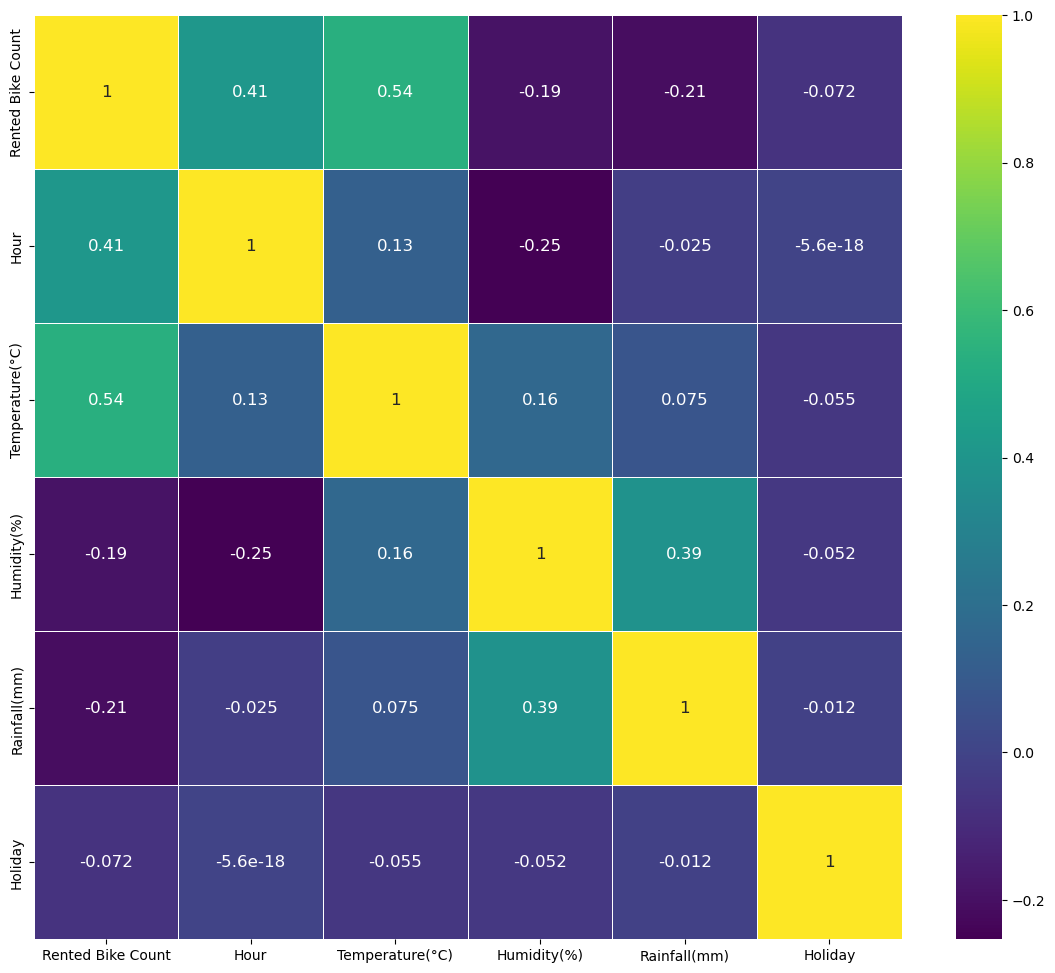

In [43]:
fig , ax = plt.subplots(figsize = (14,12))

sns.heatmap(correlation, 
            linewidths=0.5, annot=True,cmap='viridis',
            linecolor="white", annot_kws = {'size':12})

In [44]:
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
pd.DataFrame({'vif': vif[0:]}, index=X_train.columns).T

Hour  Temperature(°C)  Humidity(%)  Rainfall(mm)   Holiday
vif  1.109748         1.057521       1.3104      1.187339  1.003672

# Нормальное распределение ошибок

<AxesSubplot: ylabel='Density'>

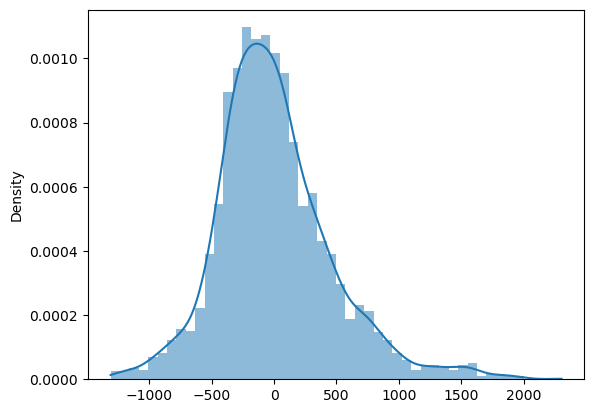

In [45]:
sns.histplot(residual, kde=True, stat="density", linewidth=0)

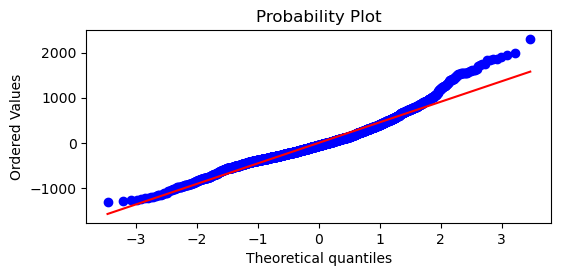

In [46]:
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual[:], plot=ax, fit=True)

In [47]:
np.mean(residual)

5.005770584621337

Можно сказать, что после удаления незначительных признаков и приведения данных к линейности, распределение остатков малозначительно изменились.

# Гомоскедастичность 

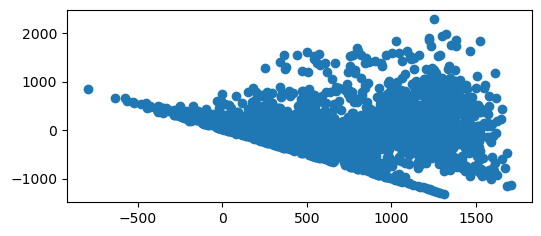

In [48]:
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_pred, residual)

In [49]:
white_test = het_white(results.resid, results.model.exog)
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
dict(zip(labels, np.round(white_test, 4)))

{'Test Statistic': 790.7215,
 'Test Statistic p-value': 0.0,
 'F-Statistic': 47.622,
 'F-Test p-value': 0.0}

Данные попрежнему гомоскдастичны, так как значение p-value для критерия Фишера равно нулю, что меньше чем допустимый уровень 0.05.

# Отсутствие автокорреляции остатков

C:\Users\Администратор\AppData\Local\Temp\ipykernel_3172\306368805.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  acf.show()


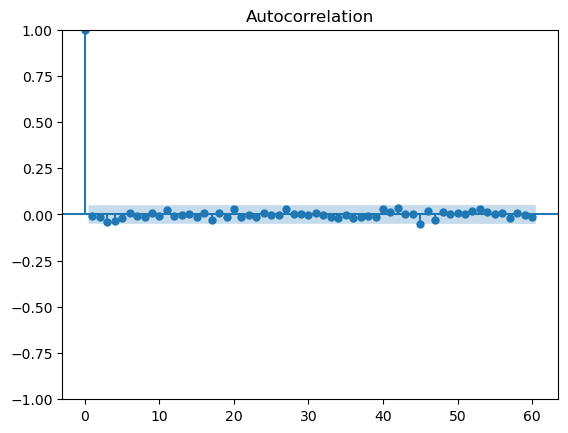

In [50]:
acf = smt.graphics.plot_acf(residual, lags=60 , alpha=0.01)
acf.show()

По графику можно сказать об отсуствиии существенной линейной взаимосвязи предикторов.


## Матрицами 

## $\beta^* = (X^T \cdot X)^{-1}\cdot X^T \cdot Y$



In [51]:
X = new_df.loc[:, new_df.columns != new_df.columns[0]]
y = new_df.loc[:, new_df.columns[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)
X_train = sm.add_constant(X_train)
b = np.linalg.inv((X_train.T @ X_train)) @ X_train.T @ y_train
b

0    703.100324
1    203.506411
2    341.211271
3    -81.157481
4   -125.590352
5    -34.582494
dtype: float64

In [52]:
X_test = sm.add_constant(X_test)
y_pred = np.dot(X_test, b.T)
np.round(y_pred[:10])

array([1020., 1359., 1456., 1091.,  472.,  783., 1473.,  792.,  983.,
        532.])

Статистика

In [53]:
np.round(mean_squared_error(y_test, y_pred), 3)

214796.827

In [54]:
np.round(mean_absolute_error(y_test, y_pred), 3)

344.856

In [55]:
np.round(r2_score(y_test, y_pred), 3)

0.476

## Градиентным спуском  

Инициализируем случайную точку (часто берут просто нули):

$$
\beta_0 = (0\;\; 0 ...)
$$

Итеративно скачем по линиям уровня нашей функции, шагая каждый раз в сторону антиградиента с корректировкой шага $\eta_k$:

$$
\beta_{k+1} = \beta_k - \eta_{k}\cdot\nabla Q(\beta_k, X)
$$
 
Останавливаемся, когда срабатывает критерий останова. Например:

$$
|\beta_{k+1} - \beta_k| < \xi
$$

Пусть имеем 3 объекта $(X, Y)^i$ = $\left((d_i, 1), Y_i \right)$ с 3 признаками $d_1$, $d_2$ (+ константа). Хотим оценить обычную линейную модель:

$$
a(x) = \beta_1 \cdot d_1 + \beta_2 \cdot d_2 + \beta_0
$$

Тогда функционал ошибки как среднеквадратическая ошибка на нашей выборке выглядит следующим образом:

$$
Q(a, X) = \frac{1}{N}\cdot\sum_{i=1}^N (\beta_1 \cdot d_{i1} + \beta_2 \cdot d_{i2} + \beta_0 - y_i)^2
$$

Посчитаем вектор-градиент по всем оцениваемым параметрам:

$$
\nabla Q(a, X) = (Q'_{\beta_1} \;\;\; Q'_{\beta_2} \;\;\; Q'_{\beta_0})
$$

Пример расчета производной по параметру у признака номер 1:

$$
Q'_{\beta_1} = \frac{2}{N} \cdot \sum_{i=1}^N d_{i1} \cdot (\beta_1 \cdot d_{i1} + \beta_2 \cdot d_{i2} + \beta_0 - y_i)
$$

In [56]:
X = new_df.loc[:, new_df.columns != new_df.columns[0]]
y = new_df.loc[:, new_df.columns[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [57]:
def gradient(X_train, y_train, iterations=20000, learning_rate = 0.01, stopping_threshold = 1e-6):
    
    X_train = (X_train - X_train.min())/(X_train.max()-X_train.min())
    
    current_weight = np.zeros(X_train.shape[1])
    current_bias = 0.0
    iterations = iterations
    learning_rate = learning_rate
    n = float(X_train.shape[0])
    costs = []
    weights = []
    previous_cost = np.inf
     
    for i in range(iterations):
         
        y_pred = np.dot(X_train, current_weight) + current_bias
        current_cost = np.square(y_train - y_pred).mean()
        if abs(previous_cost-current_cost) <= stopping_threshold:
            break
         
        previous_cost = current_cost
        
        costs.append(current_cost)
        weights.append(current_weight)
         
        weight_derivative = -(2/n) * np.dot(X_train.T, (y_train-y_pred))
        bias_derivative = -(2/n) * sum(y_train - y_pred)
         
        current_weight = current_weight - (learning_rate * weight_derivative)
        current_bias = current_bias - (learning_rate * bias_derivative)
    
    return current_weight, current_bias

weight, bias = gradient(X_train, y_train)

print('Weight:', weight)
print('Bias:', bias)

Weight: [ 696.75891797 1628.63651636 -422.25908172 -536.75293376 -159.73066101]
Bias: -266.3122579805575


In [58]:
X_test = (X_test - X_test.min())/(X_test.max()-X_test.min())
y_pred = X_test @ weight + bias
np.round(y_pred[:10])

6056    1013.0
5556    1350.0
5990    1447.0
7674    1087.0
3319     473.0
5761     776.0
5972    1465.0
8758     793.0
6079     976.0
7177     529.0
dtype: float64

Статистика

In [59]:
np.round(mean_squared_error(y_test, y_pred), 3)

214854.642

In [60]:
np.round(mean_absolute_error(y_test, y_pred), 3)

344.682

In [61]:
np.round(r2_score(y_test, y_pred), 3)

0.476

### Модуль scklearn

Нахождение коэффициентов для регрессии стохастическим градиентным спуском с помощью модуля sklearn:

In [62]:
X = new_df.loc[:, new_df.columns != new_df.columns[0]]
y = new_df.loc[:, new_df.columns[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [63]:
sgd_pipeline = Pipeline([('feature_scaling', StandardScaler()), 
                         ('sgd', SGDRegressor(max_iter=10000, early_stopping=True,
                                              eta0=0.1, tol=1e-9, validation_fraction=0.2,
                                              n_iter_no_change=10, average=20, random_state=42))])
sgd_pipeline.fit(X_train, y_train)

sgd_pipeline.steps[1][1].coef_

array([ 200.41836598,  337.72054821,  -81.84375616, -124.65511032,
        -34.58259385])

In [64]:
y_pred = sgd_pipeline.predict(X_test)
np.round(y_pred[:10])

array([1014., 1350., 1447., 1084.,  470.,  778., 1463.,  787.,  977.,
        530.])

Статистика:

In [65]:
np.round(mean_squared_error(y_test, y_pred), 3)

214809.3

In [66]:
np.round(mean_absolute_error(y_test, y_pred), 3)

344.255

In [67]:
np.round(r2_score(y_test, y_pred), 3)

0.476